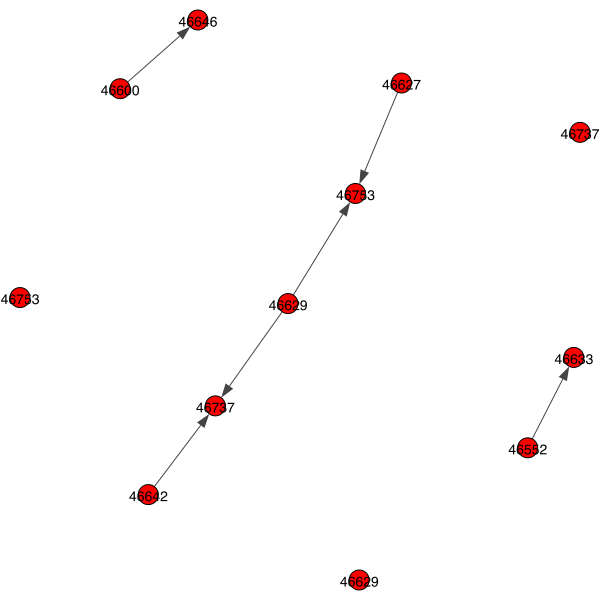

In [1]:
from igraph import *
import pandas as pd

dataframe_1 = pd.DataFrame({'ID_FROM':[46627, 46642, 46629, 46629, 46600, 46552], 'ID_TO':[46753,46737,46753,46737,46646,46633]})
#print dataframe_1
g = Graph(directed=True)
for index, row in dataframe_1.iterrows():
   g.add_vertex(str(row['ID_FROM']))
   g.add_vertex(str(row['ID_TO']))
   g.add_edge(str(row['ID_FROM']), str(row['ID_TO'])) 
g.vs["label"] = g.vs["name"]
plot(g)

In [110]:
import math
df = pd.read_csv('data/anticonflict_study_dataframe.csv')
df = df.dropna(subset=['TREAT'])
#df.apply(lambda x: x['TREAT'][1])
print(df['TREAT'])
df = df.assign(TREAT_ID = lambda x: x['TREAT'].str[1])
df['TREAT_ID']

/var/folders/04/x__0y76s1vd7_tjgq64bshr40000gn/T/ipykernel_55500/817898437.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/anticonflict_study_dataframe.csv')


0        (0) Not treatment or control
1                         (2) Control
2        (0) Not treatment or control
3        (0) Not treatment or control
4        (0) Not treatment or control
                     ...             
24460    (0) Not treatment or control
24461    (0) Not treatment or control
24462    (0) Not treatment or control
24464    (0) Not treatment or control
24465    (0) Not treatment or control
Name: TREAT, Length: 22824, dtype: object


0        0
1        2
2        0
3        0
4        0
        ..
24460    0
24461    0
24462    0
24464    0
24465    0
Name: TREAT_ID, Length: 22824, dtype: object

In [111]:
sch_dfs = []
sch_count = df['SCHID'].max()
for i in range(sch_count):
    sch_dfs.append(df.loc[df['SCHID'] == i+1])
    print(sch_dfs[i].shape[0])
print(len(sch_dfs))


246
489
126
0
104
436
604
604
371
303
459
525
261
193
103
227
319
423
478
563
400
651
766
805
789
190
251
363
268
534
370
388
365
515
344
558
157
638
421
144
472
412
114
246
348
142
289
299
373
167
502
0
818
0
224
634
266
581
551
635
60


In [112]:
spendtime_noms = ["UID","ST1", "ST2", "ST3", "ST4", "ST5", "ST6", "ST7", "ST8", "ST9", "ST10",'TREAT_ID']
conflict_noms = ["UID","CN1", "CN2", "CN3", "CN4", "CN5",'TREAT_ID']
bestfriend_noms = ["UID","ID","SCHID","BF1", "BF2",'TREAT_ID']


sch_df = sch_dfs[0]
bf = sch_df[sch_df.columns.intersection(bestfriend_noms)]
bf = bf.loc[bf['ID']!=999]
bf['TID'] = bf['UID']-bf['SCHID']*100000
bf
#bf[bf.columns] = bf[bf.columns].astype(int)

,SCHID,UID,ID,BF1,BF2,TREAT_ID,TID
0,1,100001,1,140.0,12.0,0,1
1,1,100002,2,21.0,31.0,2,2
2,1,100003,3,999.0,72.0,0,3
3,1,100004,4,19.0,32.0,0,4
4,1,100005,5,258.0,NaN,0,5
...,...,...,...,...,...,...,...
254,1,100264,264,156.0,165.0,0,264
255,1,100265,265,81.0,87.0,0,265
256,1,100266,266,202.0,196.0,1,266
257,1,100268,268,1.0,12.0,0,268


In [155]:
edge_list = []
invalid_id = [999.0]
nom_list = ["BF1", "BF2"]

for index, row in bf.iterrows():
    for nom_name in nom_list:
        if row[nom_name] not in invalid_id and not math.isnan(row[nom_name]):
            edge_list.append([row['TID'],int(row[nom_name])])
#print(edge_list)

In [156]:
import igraph
g = Graph(n = bf.shape[0],edges=edge_list,directed=True)
g.vs['name'] = list(bf['TID'])
g.vs['tid'] = list(bf['TREAT_ID'])
print(g.get_adjacency().shape)
color_dict = {"1": "red", "2": "blue", "0":'pink'}
g.vs["color"] = [color_dict[tid] for tid in g.vs["tid"]]
g.to_undirected()
print(g)
#layout = g.layout("circular")
#igraph.plot(g, layout=layout, bbox=(6000, 6000), margin=20, vertex_label = range(g.vcount()))

(273, 273)
IGRAPH UN-- 273 351 --
+ attr: color (v), name (v), tid (v)
+ edges (vertex names):
2--14, 7--15, 13--19, 5--21, 18--21, 8--22, 3--23, 10--23, 22--23, 9--24,
15--24, 17--25, 7--26, 22--26, 7--27, 7--28, 21--29, 9--30, 15--30, 17--30,
21--30, 24--30, 27--31, 28--31, 25--32, 3--33, 10--33, 20--33, 5--34, 18--34,
21--34, 35--39, 8--41, 35--43, 46--47, 47--49, 36--50, 44--50, 40--51, 35--52,
39--52, 43--52, 50--54, 44--55, 46--55, 47--55, 49--55, 52--55, 54--55,
39--56, 52--56, 27--57, 55--57, 39--58, 47--59, 48--59, 50--59, 39--60,
40--60, 49--60, 50--61, 52--61, 58--62, 39--63, 62--63, 37--64, 65--66,
65--67, 66--67, 48--68, 59--68, 62--68, 41--69, 63--69, 47--70, 62--70,
50--71, 68--71, 52--72, 60--72, 62--75, 38--77, 4--78, 46--78, 64--78, 53--88,
86--90, 87--93, 83--94, 87--94, 92--94, 85--96, 86--97, 81--98, 82--98,
88--99, 51--101, 96--102, 14--104, 83--105, 102--105, 84--106, 100--107,
86--108, 98--108, 28--109, 89--109, 100--109, 107--109, 81--110, 101--110,
68--111, 81

In [164]:
import collections
target_vertices = g.vs.select(tid_eq="1")
print(target_vertices.indices)
vs_distance = g.shortest_paths(source=g.vs, target=target_vertices)
for vertex in vs_distance:
    print(collections.Counter(vertex))

[11, 21, 23, 31, 36, 51, 66, 76, 84, 86, 93, 128, 140, 164, 208, 223, 227, 229, 243, 245, 257, 267, 269]
Counter({inf: 23})
Counter({10: 5, inf: 3, 12: 2, 5: 2, 9: 2, 16: 1, 13: 1, 14: 1, 6: 1, 1: 1, 8: 1, 7: 1, 11: 1, 15: 1})
Counter({12: 4, 11: 3, 8: 3, inf: 3, 9: 3, 1: 2, 15: 2, 5: 1, 14: 1, 10: 1})
Counter({9: 5, 6: 3, inf: 3, 8: 3, 7: 2, 13: 2, 10: 2, 4: 1, 11: 1, 1: 1})
Counter({7: 4, 9: 3, inf: 3, 11: 3, 4: 2, 6: 2, 12: 2, 10: 1, 15: 1, 8: 1, 1: 1})
Counter({11: 4, 13: 3, inf: 3, 12: 2, 9: 2, 8: 2, 10: 2, 7: 2, 16: 1, 14: 1, 15: 1})
Counter({5: 5, 8: 4, inf: 3, 7: 2, 4: 2, 11: 2, 10: 2, 3: 1, 14: 1, 6: 1})
Counter({8: 5, 10: 3, inf: 3, 2: 2, 7: 2, 11: 2, 9: 2, 4: 1, 13: 1, 12: 1, 5: 1})
Counter({8: 4, inf: 3, 6: 2, 5: 2, 10: 2, 13: 2, 11: 2, 3: 1, 7: 1, 17: 1, 12: 1, 14: 1, 4: 1})
Counter({12: 4, 11: 3, 8: 3, inf: 3, 9: 3, 1: 2, 15: 2, 5: 1, 14: 1, 10: 1})
Counter({inf: 3, 9: 3, 11: 3, 13: 2, 6: 2, 8: 2, 16: 1, 12: 1, 14: 1, 10: 1, 7: 1, 5: 1, 4: 1, 15: 1})
Counter({12: 4, inf: 